************************************************************************************
Created by: Jesus R. Burgoa
************************************************************************************
# Introduction:
************************************************************************************

# DeepFake Detection With MTCNN and PyTorch Face-Recognition Model: 

## Whats a "Deep Fake": 
(a portmanteau of "deep learning" and "fake") are synthetic media in which a person in an existing image or video is replaced with someone else's likeness. While the act of faking content is a not new, deepfakes leverage powerful techniques from machine learning and artificial intelligence to manipulate or generate visual and audio content with a high potential to deceive.

# Purpose of This Research:
While large companies like Google invest very much in fighting the DeepFakes, this including release of large datasets to help training models to counter this threat. The phenomen invades rapidly the film industry and threatens to compromise news agencies. Large digital companies, including content providers and social platforms are in the frontrun of fighting Deep Fakes. GANs that generate DeepFakes becomes better every day and, of course, if you include in a new GAN model all the information we collected until now how to combat various existent models, we create a model that cannot be beatten by the existing ones.

Just as these media are created through GAN models, they can be used to detect them. However, with given university resources, I will be demonstrating the capability of preexisting models: 
* Multi-Task Convolution Neural Networks 
* PyTorch Facial Recognition 

To develop a functional and reliable "DeepFake Detector" under supervision of my Researching Professor, Dr. Kevin Desai, and sanction of the department of Computer Science from the University of Texas at San Antonio.

************************************************************************************
# Load Libraries
************************************************************************************
************************************************************************************

In [1]:
from __future__ import print_function

# Data Processing Libraries
import os
import glob
import json
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import sys
from tqdm.notebook import tqdm

# Model Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from albumentations import Normalize, Compose
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import multiprocessing as mp
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

# Data Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Check our running device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("****************************** Debug Log: Libraries imported CORRECTLY *******************************")
print()  
print(f'                               This program runs on *** {device} *** device')
print()
print("******************************************************************************************************")

****************************** Debug Log: Libraries imported CORRECTLY *******************************

                               This program runs on *** cuda *** device

******************************************************************************************************


************************************************************************************
************************************************************************************
# PHASE I
## Analyze Data
************************************************************************************
************************************************************************************

In [2]:

""" Directory Variables """ 
TRAIN_FOLDER = 'train_videos'
TEST_FOLDER = 'test_videos'


""" Path Joining to Display Sample Counts """
print("Test Samples: ", 
      len([name for name in os.listdir(TEST_FOLDER) if os.path.isfile(os.path.join(TEST_FOLDER, name))]))

print("Train Samples: ", 
      len([name for name in os.listdir(TRAIN_FOLDER) if os.path.isfile(os.path.join(TRAIN_FOLDER, name))]))


Test Samples:  400
Train Samples:  401


************************************************************************************
## CHECK FILE TYPES
Here we check the train data files extensions. Most of the files looks to have mp4 extension, let's check if there is other extension as well.
************************************************************************************

## Training Sample File Extensions

In [3]:

""" Variables to Transfer Samples Into Extensions available """ 
train_list = os.listdir(TRAIN_FOLDER)
ext_dict = []

""" Loop Through the Training List """
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
        
""" Display Available Extensions """     
print(f"Extensions: {ext_dict}")    


Extensions: ['ipynb_checkpoints', 'mp4', 'json']


## Testing Sample File Extensions

In [4]:

""" Variables to Transfer Samples Into Extensions available """ 
test_list = os.listdir(TEST_FOLDER)
ext_dict = []

""" Loop Through the Testing List """
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)

""" Display Available Extensions """
print(f"Extensions: {ext_dict}")  


Extensions: ['mp4']


************************************************************************************
## Repeat the Process of Checking File Types:
From Testing to Training
************************************************************************************

## Training Sample File Extensions

In [5]:

""" Loop Through the Directory to Display Extension Count """
for file_ext in ext_dict:
    print(f"Files with extension for Training `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")
    

Files with extension for Training `mp4`: 400


## Testing Sample File Extensions

In [6]:

""" Loop Through the Directory to Display Extension Count """
for file_ext in ext_dict:
    print(f"Files with extension  for Testing `{file_ext}`: {len([file for file in test_list if  file.endswith(file_ext)])}")
    

Files with extension  for Testing `mp4`: 400


************************************************************************************
************************************************************************************
# PHASE II
## Analyzing Meta Data
************************************************************************************
************************************************************************************

## JSON File Located in Training Directory!

What's a JSON File? 
## A JavaScript Object Notation is an open standard file format, and data interchange format, that uses human-readable text to store and transmit data objects consisting of attribute–value pairs and array data types.
(Definition gathered from simple Google search...)

In other words, this is a dataset file, In which:
It is an incompatible file for our model's training... 

So, let's check its contents!

************************************************************************************


************************************************************************************
## Lets first check the original Meta Data
************************************************************************************

In [7]:
METADATA_PATH = TRAIN_FOLDER + '/' + 'metadata.json'

# Read the metadata file
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)
    
# Display in dataframe format
train_df = pd.DataFrame(
    [
        (video_file, metadata[video_file]['label']
         , metadata[video_file]['split']
         , metadata[video_file]['original'] if 'original' in metadata[video_file].keys() else '')
        for video_file in metadata.keys()
    ],
    columns=['filename', 'label', 'split', 'original']
)

train_df.head()

,filename,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


************************************************************************************
************************************************************************************
# PHASE III
## Face Detection Processing
************************************************************************************
************************************************************************************

# Define Face Extractor Class
## Purpose: detecting faces in the frames of a video file.
************************************************************************************

In [8]:
# Hyper-paramters used for faceExtractor (processing png frames for training)

SCALE = 0.25
N_FRAMES = None

In [9]:
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length (VideoCapture)
        v_cap = cv2.imread(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces    


def process_faces(faces, resnet):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = resnet(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).gpu().numpy()
    
    return x

In [10]:
class FaceExtractor:
    def __init__(self, detector, n_frames=None, resize=None):
        """
        Parameters:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """

        self.detector = detector
        self.n_frames = n_frames
        self.resize = resize
    
    def __call__(self, filename, save_dir):
        """Load frames from an MP4 video, detect faces and save the results.

        Parameters:
            filename {str} -- Path to video.
            save_dir {str} -- The directory where results are saved.
        """

        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])

                save_path = os.path.join(save_dir, f'{j}.png')

                self.detector([frame], save_path=save_path)

        v_cap.release()

In [11]:
# Load face detector
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

In [12]:
# Define face extractor
face_extractor = FaceExtractor(detector=face_detector, n_frames=N_FRAMES, resize=SCALE)

In [16]:
# Get the paths of all train videos
all_train_videos = glob.glob(os.path.join(TRAIN_FOLDER, '*.mp4'))

# Get the paths of all test videos
all_test_videos = glob.glob(os.path.join(TEST_FOLDER, '*.mp4'))

In [14]:
!mkdir TMP_DIR

TMP_DIR = 'TMP_DIR/'
print(TMP_DIR)

TMP_DIR/


A subdirectory or file TMP_DIR already exists.


In [15]:
with torch.no_grad():
    for path in tqdm(all_train_videos):
        file_name = path.split('/')[-1]

        save_dir = os.path.join(TMP_DIR, file_name.split(".")[0])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Detect all faces appear in the video and save them.
        face_extractor(path, save_dir)
        
# train_df.to_csv('metadata.csv', index=False)

KeyboardInterrupt: 

In [17]:
with torch.no_grad():
    for path in tqdm(all_test_videos):
        file_name = path.split('/')[-1]

        save_dir = os.path.join(TMP_DIR, file_name.split(".")[0])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Detect all faces appear in the video and save them.
        face_extractor(path, save_dir)
        
# train_df.to_csv('metadata.csv', index=False)

KeyboardInterrupt: 

************************************************************************************
************************************************************************************
# PHASE IV.I
## Clean Data and Prepare to Train
************************************************************************************
************************************************************************************

## Configure hyper-parameters

In [18]:
# Some Hyper Parameters
PRETRAINED_MODEL_PATH = ''

N_FACES = 5
TEST_SIZE = 0.3
RANDOM_STATE = 123

BATCH_SIZE = 32
NUM_WORKERS = mp.cpu_count()

WARM_UP_EPOCHS = 10
WARM_UP_LR = 1e-4
FINE_TUNE_EPOCHS = 100
FINE_TUNE_LR = 1e-6

THRESHOLD = 0.5
EPSILON = 1e-7

# Define useful class and function
************************************************************************************

In [19]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, encoder, in_channels=3, num_classes=1):
        super(DeepfakeClassifier, self).__init__()
        self.encoder = encoder
        
        # Modify input layer.
        self.encoder.conv1 = nn.Conv2d(
            in_channels,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        
        # Modify output layer.
        self.encoder.fc = nn.Linear(512 * 1, num_classes)

    def forward(self, x):
        return torch.sigmoid(self.encoder(x))
    
    def freeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = False

    def freeze_middle_layers(self):
        self.freeze_all_layers()
        
        for param in self.encoder.conv1.parameters():
            param.requires_grad = True
            
        for param in self.encoder.fc.parameters():
            param.requires_grad = True

    def unfreeze_all_layers(self):
        for param in self.encoder.parameters():
            param.requires_grad = True


class FaceDataset(Dataset):
    def __init__(self, img_dirs, labels, n_faces=1, preprocess=None):
        self.img_dirs = img_dirs
        self.labels = labels
        self.n_faces = n_faces
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_dir = self.img_dirs[idx]
        label = self.labels[idx]
        face_paths = glob.glob(TMP_DIR + f'trained_pngs/{img_dir}/*.png')

        if len(face_paths) >= self.n_faces:
            sample = np.random.choice(face_paths, self.n_faces, replace=False)
        else:
            sample = np.random.choice(face_paths, self.n_faces, replace=True)
            
        faces = []
        
        for face_path in sample:
            face = cv2.imread(face_path, 1)
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            if self.preprocess is not None:
                augmented = self.preprocess(image=face)
                face = augmented['image']
            faces.append(face)

        return {'faces': np.concatenate(faces, axis=-1).transpose(2, 0, 1), 'label': np.array([label], dtype=float)}
    
    
class FaceValDataset(Dataset):
    def __init__(self, img_dirs, labels, n_faces=1, preprocess=None):
        self.img_dirs = img_dirs
        self.labels = labels
        self.n_faces = n_faces
        self.preprocess = preprocess

    def __len__(self):
        return len(self.img_dirs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_dir = self.img_dirs[idx]
        label = self.labels[idx]
        face_paths = glob.glob(TMP_DIR + f'trained_pngs/{img_dir}/*.png')

        face_indices = [
            path.split('/')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]        
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(self.n_faces):
            stride = int((max_idx + 1)/(self.n_faces**2))
            sample = np.linspace(i*stride, max_idx + i*stride, self.n_faces).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(f'{img_dir}/{idx}*.png')

                selected_paths.extend(paths)

                if len(selected_paths) >= self.n_faces:
                    break
            
            if len(selected_paths) >= self.n_faces:
                break

        faces = []

        selected_paths = selected_paths[:self.n_faces] # Get top
        for selected_path in selected_paths:
            img = cv2.imread(selected_path, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces.append(img)

        if self.preprocess is not None:
            for j in range(len(faces)):
                augmented = self.preprocess(image=faces[j])
                faces[j] = augmented['image']

        faces = np.concatenate(faces, axis=-1).transpose(2, 0, 1)

        return {
            'faces': faces,
            'label': np.array([label], dtype=float)
        }


class FocalLoss(nn.Module):
    def __init__(self, gamma=2, sample_weight=None):
        super().__init__()
        self.gamma = gamma
        self.sample_weight = sample_weight

    def forward(self, logit, target):
        target = target.float()
        max_val = (-logit).clamp(min=0)
        loss = logit - logit * target + max_val + \
               ((-max_val).exp() + (-logit - max_val).exp()).log()

        invprobs = F.logsigmoid(-logit * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        if len(loss.size())==2:
            loss = loss.sum(dim=1)
        if self.sample_weight is not None:
            loss = loss * self.sample_weight
        return loss.mean()

NameError: name 'Dataset' is not defined


------------------------------------------------------
------------------------------------------------------
# Find and Merge Datasets

In [20]:
!mkdir SAVE_DATA

# Assign some foler variables
INPUT_DIR = 'Research_Deep_Fake Docs/INPUT/'
SAVE_PATH = 'Research_Deep_Fake Docs/SAVE_DATA/' # The location where the model should be saved.
PRETRAINED_MODEL_PATH = ''

print(INPUT_DIR)
print(SAVE_PATH)

Research_Deep_Fake Docs/INPUT/
Research_Deep_Fake Docs/SAVE_DATA/


A subdirectory or file SAVE_DATA already exists.


In [21]:
all_train_dirs = glob.glob(TMP_DIR + 'trained_pngs' )
all_train_dirs = sorted(all_train_dirs, key=lambda x: x)
for i, train_dir in enumerate(all_train_dirs):
    print('[{:02}]'.format(i), train_dir)

[00] TMP_DIR/trained_pngs


In [22]:
all_dataframes = list()

df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
df['path'] = df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))
all_dataframes.append(df)

train_df = pd.concat(all_dataframes, ignore_index=True, sort=False)
train_df.head()

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,TMP_DIR/trained_pngs\aagfhgtpmv
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,TMP_DIR/trained_pngs\aapnvogymq
2,abarnvbtwb.mp4,REAL,train,NaN,TMP_DIR/trained_pngs\abarnvbtwb
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,TMP_DIR/trained_pngs\abofeumbvv
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,TMP_DIR/trained_pngs\abqwwspghj


************************************************************************************
************************************************************************************
# PHASE IV.II
## CLEAN new dataframe
************************************************************************************
************************************************************************************

* Remove corrupt videos or ones in what cannot detect any faces
* These videos will result in empty folders after the data preparation process.

In [23]:
# Remove empty folders
train_df = train_df[train_df['path'].map(lambda x: os.path.exists(x))]

In [24]:
train_df.head()

,filename,label,split,original,path
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4,TMP_DIR/trained_pngs\aagfhgtpmv
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4,TMP_DIR/trained_pngs\aapnvogymq
2,abarnvbtwb.mp4,REAL,train,NaN,TMP_DIR/trained_pngs\abarnvbtwb
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4,TMP_DIR/trained_pngs\abofeumbvv
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4,TMP_DIR/trained_pngs\abqwwspghj


## * Remove videos in which do not have enough faces
### Important to prevent producing inappropriate samples during the training and validation processes.

In [25]:
valid_train_df = pd.DataFrame(columns=['filename', 'label', 'split', 'original', 'path'])

# for row_idx, row in tqdm(train_df.iterrows()):
for row_idx in tqdm(train_df.index):
    row = train_df.loc[row_idx]
    img_dir = row['path']
    face_paths = glob.glob(TMP_DIR + f'trained_pngs/{img_dir}/*.png')

    if len(face_paths) >= N_FACES: # Satisfy the minimum requirement for the number of faces
        face_indices = [
            path.split('/')[-1].split('.')[0].split('_')[0]
            for path in face_paths
        ]
        max_idx = np.max(np.array(face_indices, dtype=np.uint32))

        selected_paths = []

        for i in range(N_FACES):
            stride = int((max_idx + 1)/(N_FACES**2))
            sample = np.linspace(i*stride, max_idx + i*stride, N_FACES).astype(int)

            # Get faces
            for idx in sample:
                paths = glob.glob(TMP_DIR + f'trained_pngs/{img_dir}/{idx}*.png')

                selected_paths.extend(paths)
                if len(selected_paths) >= N_FACES: # Get enough faces
                    break
                    
    valid_train_df = valid_train_df.append(row, ignore_index=True)
    
    

In [26]:
valid_train_df['label'].replace({'FAKE': 1, 'REAL': 0}, inplace=True)

valid_train_df.head()

,filename,label,split,original,path
0,aagfhgtpmv.mp4,1,train,vudstovrck.mp4,TMP_DIR/trained_pngs\aagfhgtpmv
1,aapnvogymq.mp4,1,train,jdubbvfswz.mp4,TMP_DIR/trained_pngs\aapnvogymq
2,abarnvbtwb.mp4,0,train,NaN,TMP_DIR/trained_pngs\abarnvbtwb
3,abofeumbvv.mp4,1,train,atvmxvwyns.mp4,TMP_DIR/trained_pngs\abofeumbvv
4,abqwwspghj.mp4,1,train,qzimuostzz.mp4,TMP_DIR/trained_pngs\abqwwspghj


In [27]:
label_count = valid_train_df.groupby('label').count()['filename']
print(label_count)

label
0     77
1    323
Name: filename, dtype: int64


************************************************************************************
************************************************************************************
# PHASE IV.III
## Start the training process
************************************************************************************
************************************************************************************

In [28]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

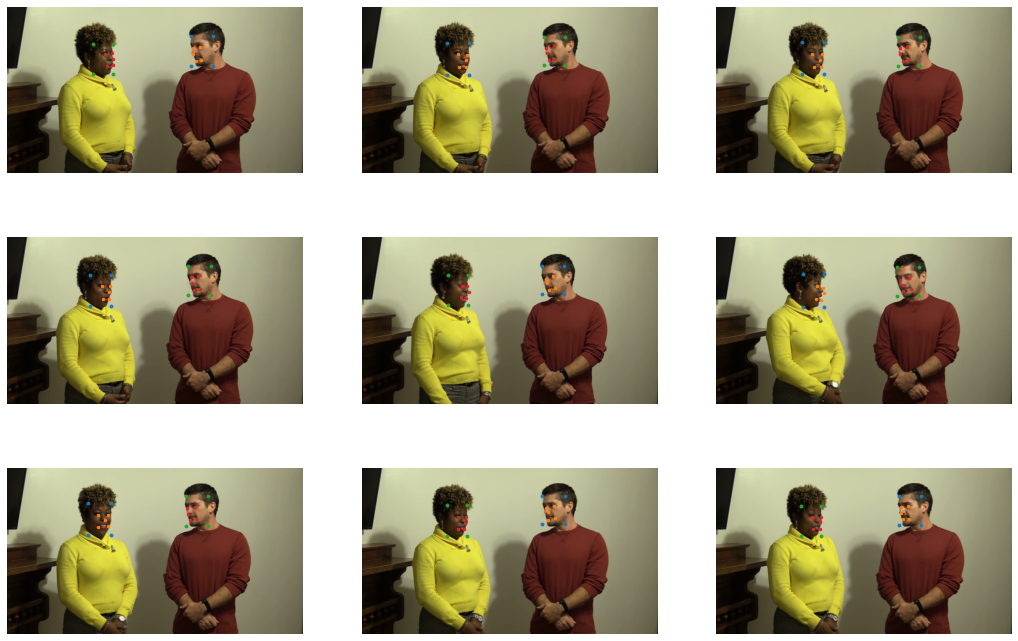

In [33]:
# Load a video
v_cap = cv2.VideoCapture('train_videos/avibnnhwhp.mp4')

# Loop through video
batch_size = 32
frames = []
boxes = []
landmarks = []
view_frames = []
view_boxes = []
view_landmarks = []
for _ in tqdm(range(v_len)):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch, resizing for speed
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    frame = frame.resize([int(f * 0.25) for f in frame.size])
    frames.append(frame)
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        batch_boxes, _, batch_landmarks = mtcnn.detect(frames, landmarks=True)
        boxes.extend(batch_boxes)
        landmarks.extend(batch_landmarks)
        
        view_frames.append(frames[-1])
        view_boxes.append(boxes[-1])
        view_landmarks.append(landmarks[-1])
        
        frames = []

# Visualize
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
for i in range(9):
    ax[int(i / 3), i % 3].imshow(view_frames[i])
    ax[int(i / 3), i % 3].axis('off')
    for box, landmark in zip(view_boxes[i], view_landmarks[i]):
        ax[int(i / 3), i % 3].scatter(*np.meshgrid(box[[0, 2]], box[[1, 3]]), s=8)
        ax[int(i / 3), i % 3].scatter(landmark[:, 0], landmark[:, 1], s=6)

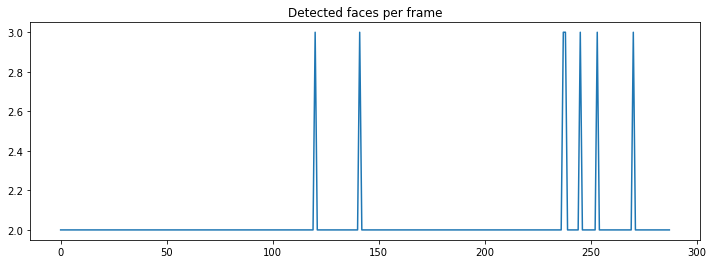

In [31]:
# Load a video
v_cap = cv2.VideoCapture('train_videos/avibnnhwhp.mp4')
v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through video
batch_size = 16
frames = []
faces = []
for _ in tqdm(range(v_len)):
    
    # Load frame
    success, frame = v_cap.read()
    if not success:
        continue
        
    # Add to batch
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(Image.fromarray(frame))
    
    # When batch is full, detect faces and reset batch list
    if len(frames) >= batch_size:
        faces.extend(mtcnn(frames))
        frames = []

plt.figure(figsize=(12, 4))
plt.plot([len(f) for f in faces])
plt.title('Detected faces per frame');

In [34]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25)

# Get all test videos
filenames_train = glob.glob('train_videos/*.mp4')

X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames_train), total=len(filenames_train)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(process_faces(faces, resnet))

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPUTensorId, CUDATensorId, QuantizedCPUTensorId, VariableTensorId]
There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPUTensorId, CUDATensorId, QuantizedCPUTensorId, VariableTensorId]
There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPUTensorId, CUDATensorId, QuantizedCPUTensorId, VariableTensorId]
There were no tensor argu

In [35]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=60, resize=0.25)

# Get all test videos
filenames_test = glob.glob('test_videos/*.mp4')

X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(filenames_test), total=len(filenames_test)):
        try:
            0# Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(process_faces(faces, resnet))

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

Frames per second (load+detect+embed):   20.5


************************************************************************************
************************************************************************************
# PHASE V
## VISUAL & STATISTICAL RESULTS
************************************************************************************
************************************************************************************

In [45]:
bias = -0.2942
weight = 0.68235746

result_train = []
for filename, x_i in zip(filenames_train, X):
    if x_i is not None:
        prob = 1 / (1 + np.exp(-(bias + (weight * x_i).mean())))
    else:
        prob = 0.5
    result_train.append([os.path.basename(filename), prob])

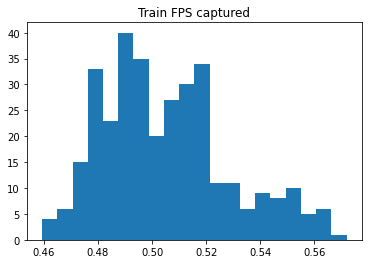

In [51]:
result_train = pd.DataFrame(result_train, columns=['filename', 'label'])
result_train.sort_values('filename').to_csv('result_train.csv', index=False)

plt.title("Train FPS captured")
plt.hist(result_train.label, 20)
plt.show()

In [49]:
bias = -0.2942
weight = 0.68235746

result_test = []
for filename, x_i in zip(filenames_test, X):
    if x_i is not None:
        prob = 1 / (1 + np.exp(-(bias + (weight * x_i).mean())))
    else:
        prob = 0.5
    result_test.append([os.path.basename(filename), prob])

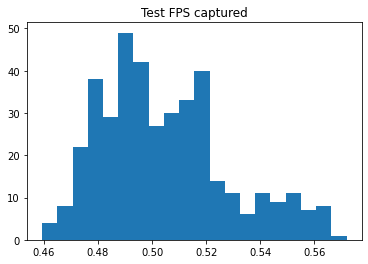

In [52]:
result_test = pd.DataFrame(result_test, columns=['filename', 'label'])
result_test.sort_values('filename').to_csv('result_test.csv', index=False)

plt.title("Test FPS captured")
plt.hist(result_test.label, 20)
plt.show()

(array([ 77.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 323.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

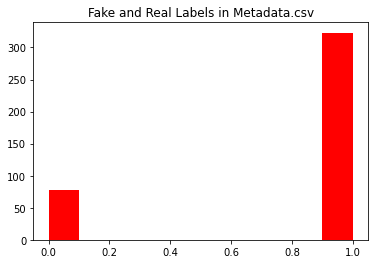

In [55]:
plt.title("Fake and Real Labels in Metadata.csv")
plt.hist(valid_train_df['label'], align='mid', color='r')